/var/folders/d4/shs1przn7kv14dtw8dyw_k680000gn/T/ipykernel_39382/3438729020.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/var/folders/d4/shs1przn7kv14dtw8dyw_k680000gn/T/ipykernel_39382/3438729020.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


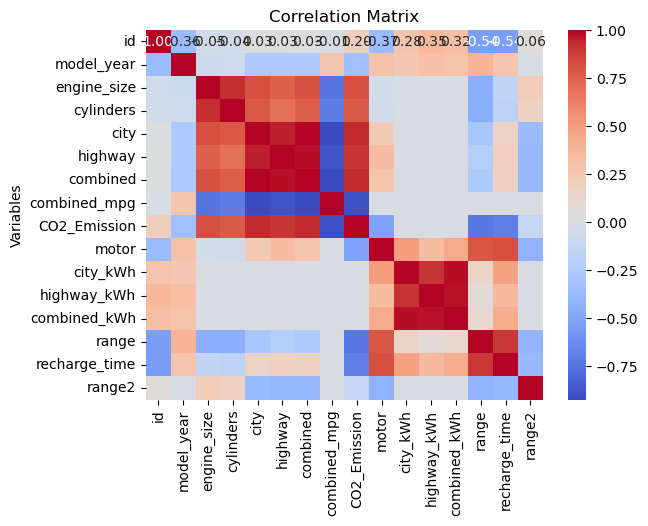

In [1]:
import numpy as np
import pandas as pd

# for plotting the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# recommendation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import psycopg2
# Establish connection
conn = psycopg2.connect(dbname="postgres", user="postgres", password="postgres", host="localhost", port="5432")

# SQL query
query = """
    SELECT id, model_year, make, car_model, vehicle_class, engine_size, cylinders, transmission,
           fuel_type, city, highway, combined, combined_mpg, "CO2_Emission",
           motor, "city_kWh", "highway_kWh", "combined_kWh", range, recharge_time, 
           fuel_type2, range2, "combined_PHEV", vehicle_type
    FROM datamining_carinfomodel;
"""

df = pd.read_sql_query(query, conn)

# Store the row IDs separately for future reference if needed
original_row_ids = df['id']

# Find correlation matrix

correlation_matrix = df.corr()
correlation_matrix.fillna(0, inplace=True)

# Plot correlation matrix as a heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", annot=True)
plt.title('Correlation Matrix')
plt.ylabel('Variables')
# TODO figure out text in th cells
# c = plt.pcolor(correlation_matrix, edgecolors='k', linewidths=4, cmap='RdBu', vmin=0.0, vmax=1.0)
# plt.colorbar(c)
# Save the plot as an image file
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# recommendation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import psycopg2
# Establish connection
conn = psycopg2.connect(dbname="postgres", user="postgres", password="postgres", host="localhost", port="5432")

# SQL query
query = """
    SELECT id, model_year, make, car_model, vehicle_class, engine_size, cylinders, transmission,
           fuel_type, city, highway, combined, combined_mpg, "CO2_Emission",
           motor, "city_kWh", "highway_kWh", "combined_kWh", range, recharge_time, 
           fuel_type2, range2, "combined_PHEV", vehicle_type
    FROM datamining_carinfomodel;
"""
#    WHERE model_year > 2015;

df = pd.read_sql_query(query, conn)

# Preprocessing

# Saving IDs
ids = df['id'].tolist()

# Each variable is converted in as many 0/1 variables as there are different values.
# Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value.
transformer = pd.get_dummies(df)
scaler = MinMaxScaler()
scale_columns = ['engine_size', 'cylinders', 'city' , 'highway','combined', 'combined_mpg', 'CO2_Emission']
transformer[scale_columns] = scaler.fit_transform(transformer[scale_columns])
transformer.fillna(0, inplace=True)

# Adding IDs back
transformer['id'] = ids

NUMBER_OF_ONLY_EV = 10
NUMBER_OF_HYBRID_WITH_EV = 6
NUMBER_OF_EV_WITH_HYBRID = 4
NUMBER_OF_CONVENTIONAL_WITH_HYBRID = 6
NUMBER_OF_HYBRID_WITH_CONVENTIONAL = 4
NUMBER_OF_RESULT = 100

def calculate_and_show_similarity_score(source_car_id, filter_carbon_emission=False):
    # source_car = df[df.index == source_car_id].iloc[0]  # Get the source car from the DataFrame using its ID
    source_car = df[df['id'] == source_car_id].iloc[0]

    source_vehicle_type = source_car['vehicle_type']
    recommended_cars = {}

    source_car_index = df.index[df['id'] == source_car_id][0]

    similarity_score = []

    if source_vehicle_type == "BEV":
        weighted_data = transformer.copy()
        user_weights = {'motor': 0.75, 'city_kWh': 0.7, 'highway_kWh': 0.8, 'combined_kWh': 0.9, 'range': 0.9, 'recharge_time': 0.9, 'CO2_Emission': 0.1}
        weighted_data[['motor', 'city_kWh', 'highway_kWh', 'combined_kWh','range', 'recharge_time', 'CO2_Emission']]*= user_weights
        similarity_scores = cosine_similarity(weighted_data.values, transformer.values)

        similarity_df = pd.DataFrame(similarity_scores, index=df['id'], columns=df['id'])
        similarity_df.show()

        # Get indices of top similar cars
        # Exclude self-similarity and get top <NUMBER_OF_RESULTS> similar cars
        top_similar_indices = similarity_scores[source_car_index].argsort()[::-1][1:NUMBER_OF_ONLY_EV+1]

    elif source_vehicle_type == "PHEV":
        weighted_data_hybrid = transformer.copy()
        user_weights_hybrid = {'engine_size': 0.8,'cylinders': 0.8,'city':0.8,'highway':0.8,'combined':0.85,'motor': 0.6,'range': 0.9, 'recharge_time': 0.8,'range2':0.85, 'CO2_Emission': 0.1}
        weighted_data_hybrid[['engine_size','cylinders','city','highway','combined','motor','range', 'recharge_time','range2', 'CO2_Emission']] *= user_weights_hybrid
        similarity_scores_hybrid = cosine_similarity(weighted_data_hybrid.values, transformer.values)

        similarity_hybrid_df = pd.DataFrame(similarity_scores_hybrid, index=df['id'], columns=df['id'])
        similarity_hybrid_df.show()

        weighted_data_electric =  transformer.copy()
        user_weights_electric= {'motor': 0.75, 'range': 0.9, 'recharge_time': 0.9, 'CO2_Emission': 0.1}
        weighted_data_electric[['motor','range', 'recharge_time','CO2_Emission']] *= user_weights_electric
        similarity_scores_electric = cosine_similarity(weighted_data_electric.values, transformer.values)
        
        similarity_electric_df = pd.DataFrame(similarity_scores_electric, index=df['id'], columns=df['id'])
        similarity_electric_df.show()

    elif source_vehicle_type == "Conventional":
        max_CO2_emission_limit = source_car['CO2_Emission']
        
        # Convesntional 
        weighted_data_conventional = transformer.copy()
        user_weights_conventional = {'engine_size': 0.6, 'cylinders': 0.55, 'city': 0.85, 'highway': 0.8, 'combined': 0.6, 'combined_mpg': 0.85, 'CO2_Emission': 0.1}
        weighted_data_conventional[['engine_size', 'cylinders', 'city', 'highway', 'combined', 'combined_mpg', 'CO2_Emission']] *= user_weights_conventional
        similarity_scores_conventional = cosine_similarity(weighted_data_conventional.values, transformer.values)

        similarity_conventional_df = pd.DataFrame(similarity_scores_conventional, index=df['id'], columns=df['id'])
        similarity_conventional_df.show()

        # Hybrid
        weighted_data_hybrid = transformer.copy()
        user_weights_hybrid = {'engine_size': 0.8,'cylinders': 0.8,'city':0.8,'highway':0.8,'combined':0.85,'motor': 0.6,'range': 0.9, 'recharge_time': 0.8,'range2':0.85, 'CO2_Emission': 0.1}
        weighted_data_hybrid[['engine_size','cylinders','city','highway','combined','motor','range', 'recharge_time','range2', 'CO2_Emission']] *= user_weights_hybrid
        similarity_scores_hybrid = cosine_similarity(weighted_data_hybrid.values, transformer.values)
        
        similarity_hybrid_df = pd.DataFrame(similarity_scores_hybrid, index=df['id'], columns=df['id'])
        similarity_hybrid_df.show()

# Example usage:
# conventional
source_car_id = 22000
calculate_and_show_similarity_score(source_car_id)
# hybrid
# source_car_id = 750
# EV
# source_car_id = 450
# filter_carbon_emission = True

# source_car = df[df['id'] == source_car_id].iloc[0]
# print(f"\nRecommendations for Source Car: {source_car['id']} {source_car['make']} {source_car['car_model']} ({source_car['model_year']}) CO2 emissions: {source_car['CO2_Emission']} g/km")

# recommended_cars = recommend_similar_cars_1(source_car_id)
# print("Similar cars with CO2 emissions (sorted by ascending order):")
# recommended_cars_sorted = sorted(recommended_cars, key=lambda x: x[3])  # Sort recommended cars by CO2 emissions
# # print(recommended_cars_sorted)

# for rec in enumerate(recommended_cars_sorted):
#     real_car_id = rec[1][0]  # Extracting the real car ID from the tuple
#     print(f"{real_car_id}. {rec[1][1]} {rec[1][2]} ({rec[1][3]}), CO2 emissions: {rec[1][4]} g/km")

